# k-最近邻（kNN）练习
kNN分类器由两个阶段组成：
-在训练过程中，分类器获取训练数据并简单地记住它
-在测试过程中，kNN通过与所有训练图像进行比较并转移k个最相似训练示例的标签来对每个测试图像进行分类
-k的值经过交叉验证
在本练习中，您将实现这些步骤，了解基本的图像分类管道、交叉验证，并熟练编写高效的矢量化代码。

In [1]:
# 一些KNN算法的准备工作

# Run some setup code for this notebook.

import random
import numpy as np
from dlcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
# %matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.show()
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'dlcv/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


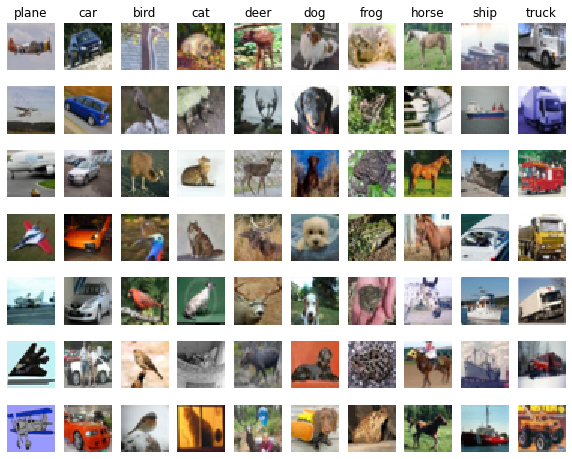

In [3]:
# 从数据集中选择部分样例进行可视化
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)#返回非0元素的位置，即等于y的位置
    idxs = np.random.choice(idxs, samples_per_class, replace=False)#从idx中随机选出七张
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))#展示图像数据
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 对数据进行子采样，以便在本练习中更高效地执行代码

# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
#创建一个kNN分类器实例。
#请记住，训练kNN分类器是一个技巧：
#分类器只记住数据，不进行进一步处理

from dlcv.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

我们现在想用kNN分类器对测试数据进行分类。回想一下，我们可以将此过程分解为两个步骤：
1.首先，我们必须计算所有测试示例和所有训练示例之间的距离。
2.给定这些距离，对于每个测试示例，我们找到k个最接近的示例，并让它们投票给标签

让我们从计算所有训练和测试示例之间的距离矩阵开始。例如，如果存在**Ntr**训练示例和**Nte**测试示例，则该阶段应产生**Nte x Ntr**矩阵，其中每个元素（i，j）是第i个测试和第j个训练示例之间的距离。

**注意：对于我们要求您在代码中实现的三个距离计算，您可能不会使用numpy提供的np.linalg.norm（）函数**
首先，打开“dlcv/classifiers/k_nearest_neighbor.py”并实现函数“compute_dinstances _two_loops”，该函数在所有成对的（测试、训练）示例上使用（非常低效的）双环，并一次计算一个元素的距离矩阵。

In [7]:
# 打开dlcv/classifiers/k_nearest_neighbor.py并实现
# Open dlcv/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
# 测试你的实现代码:
a=np.random.rand(3)
b=np.random.rand(3)
print(a)
print(b)
print(np.square(a-b))
print(np.sum(np.square(a-b)))

dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

[0.79700451 0.62232591 0.31273757]
[0.29980053 0.15248987 0.27395939]
[0.2472118  0.2207459  0.00150375]
0.4694614465562177
(500, 5000)


In [ ]:
# 我们可以可视化距离矩阵：每一行都是一个单独的测试示例
# 它与训练实例的距离

# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples

plt.imshow(dists, interpolation='none')
plt.show()

**问题1**

请注意距离矩阵中的结构化图案，其中一些行或列明显更亮。（请注意，在默认配色方案中，黑色表示低距离，而白色表示高距离。）

-数据中明显明亮的行背后的原因是什么？
-是什么导致了这些列？

$\color{blue}{\textit 你的回答:}$ *每一行代表一个测试图像，对于第一个问题：越亮表示L2距离（该图像与训练集图像）越远，每一列表示一个训练数据，对于第二个问题：越亮表明该训练图像与测试集的L2距离较远*



In [ ]:
# 实现函数 predict_labels 并在下面运行:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor)

y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

您应该期望看到大约“27%”的准确率。现在让我们尝试一个更大的“k”，比如“k=5”：

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

您应该期望看到比“k=1”稍好的性能。

**问题 2**

我们也可以使用其它的距离度量，如L1距离。
对于图片 $I_k$ 特定像素点 $(i,j)$ 的值 $p_{ij}^{(k)}$
所有图片像素均值 $\mu$ 为：
$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
并且所有图片特定位置像素点的均值 $\mu_{ij}$ 为：
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
类似地，定义了一般标准偏差 $\sigma$ 和逐像素标准偏差$\sigma_{ij}$。

以下哪一个预处理步骤不会改变使用L1距离的最近邻分类器的性能？选择所有适用的选项。说明一点，训练和测试示例都以相同的方式进行了预处理。

1. 减去均值 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. 减去每个像素的均值 $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. 减去均值 $\mu$ 并除以标准差 $\sigma$.
4. 减去逐像素均值 $\mu_{ij}$ 并除以逐像素标准差 $\sigma_{ij}$.
5. 旋转数据的坐标轴，这意味着将所有图像旋转相同的角度。图像中由旋转引起的空区域用相同的像素值填充，并且不执行插值。

$\color{blue}{\textit 你的回答:1 2 3}$


$\color{blue}{\textit 你的解释:首先要说明什么是L1距离：L1 = |x1 - x2| + |y1 - y2|绝对值距离，问题转化为哪些预处理方式，使得使用绝对值距离进行最临近分类，不改变性能或影响不大。预处理一和二，减去均值后，并不改变差值，预处理三相当于坐标标准化，不改变L1距离差距；预处理四并非标准化；预处理五填充处可能会影响L1计算的误差}$


In [ ]:
# 现在让我们通过使用部分矢量化来加快距离矩阵的计算。
# 实现函数compute_dinstance_one_loop并运行以下代码

dists_one = classifier.compute_distances_one_loop(X_test)

# 为了确保我们的矢量化实现是正确的，我们确保它与直接的实现一致。
# 有很多方法可以决定两个矩阵是否相似；其中最简单的是Frobenius范数，两个矩阵的Frobenius范数是所有元素差的平方和的平方根；
# 换句话说，将矩阵重塑为向量，并计算它们之间的欧几里得距离。

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
#现在在compute_dinstances _no_loops中实现完全矢量化的版本并运行代码

dists_two = classifier.compute_distances_no_loops(X_test)

# 检查距离矩阵是否与我们之前计算的一致:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# 让我们比较一下实现的速度

# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# 使用完全矢量化的实现，您应该可以看到明显更快的性能！

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

### 交叉验证
我们已经实现了k-最近邻分类器，但是我们任意地设置值k=5。我们现在将通过交叉验证来确定这个超参数的最佳值。

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
##################################################################################
# TODO:                                                                          #
# 将训练数据拆分为多个份。拆分后，X_train_folds和y_train_foldds应分别为长度num_folds的列表 #
# 其中y_train_folds[i]是X_train_folds[i]中的点的标签向量                             #
# 提示：查找numpy array_split函数。                                                 #
################################################################################
# *****     代码的开头（不要删除/修改此行）        *****

y_train_folds = np.array_split(y_train,num_folds)
x_train_folds = np.array_split(x_train,num_folds)

# *****     代码的结尾（不要删除/修改此行）        *****

# 一个字典，保存我们在运行交叉验证时发现的不同k值的准确性。
# 在运行交叉验证之后，k_to_accurcies[k]应该是长度num_folds的列表，
# 给出了我们在使用k的值时发现的不同精度值。
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# 执行k次交叉验证以找到k的最佳值。对于k的每个可能值，运行k次近邻算法num_folds次，          #
# 在每种情况下，您都使用除某一份数据外的所有数据作为训练数据，最后一份数据作为验证集。          #
# 将k的所有份数和所有值的精度存储在k_to_accurces字典中。                              #
################################################################################
# *****     代码的开头（不要删除/修改此行）        *****

for k in k_choices:
    #初始化
    k_to_accuracies[k] = []
    for item in range(num_folds):
        ttrain_x = np.concatenate((np.compress([False if temp_i == i else True for temp_i in range(num_folds)],X_train_folds,axis=0))
        ttrain_y = np.concatenate(np.compress([False if temp_i == i else True for temp_i in range(num_folds)],y_train_folds,axis=0))
        #开始训练
        classifier.train(ttrain_x,ttrain_y)
        #预测
        tpy = classifier.predict(x_train_folds[i],k = k , num_loops = 0)
        
        corect = np.sum(tpy == y_train_folds[i])
      
        k_to_accuracies[k].append(correct_count / len(tpy))
                                  
# *****     代码的结尾（不要删除/修改此行）        *****

# 打印出计算的准确率
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# 绘制原始观测结果
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# 基于上述交叉验证结果，选择k的最佳值，
# 使用所有训练数据重新训练分类器，并在测试数据上进行测试。
# 你应该能够在测试数据上获得超过28%的准确率。
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**问题 3**

以下关于 $k$ -最近邻居（$k$-NN）的语句中的哪一个在分类设置中是正确的，并且对于所有 $k$ 都是正确的？选择所有适用的选项。
1.k-NN分类器的判定边界是线性的。
2.1-NN的训练误差将始终低于或等于5-NN的训练错误。
3.1-NN的测试误差将始终低于5-NN的测试错误。
4.使用k-NN分类器对测试示例进行分类所需的时间随着训练集的大小而增长。
5.以上均无。

$\color{blue}{\textit 你的回答:２　４}$


$\color{blue}{\textit 你的解释:对于１：决定边界非线性，根据算法算出来的结果去找出现最多的类别标签；\t 对于２：训练集中１ＮＮ所取样本是其本身，而５ＮＮ中不一定是属于自己的类别标签最多，因此１ＮＮ一定比５误差低 \t；对于３：测试集中则不一定\t对于４：训练集体量变大，每个测试样本都要与其进行计算，花销更多}$
